# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [8]:
import sys
print("Python %s" % sys.version)
import random
from collections import namedtuple, deque

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [275]:
import gym
print("OpenAI Gym %s" % gym.__version__)
from gym import wrappers

OpenAI Gym 0.14.0


In [11]:
import torch
print("PyTorch %s" % torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

PyTorch 1.2.0


In [5]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline

matplotlib 3.1.1


In [236]:
from IPython import display

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

Use the code cell below to create an instance of the [LunarLander](https://github.com/openai/gym/blob/ce9b4e486a3c9770fd5c791665d55d5eb96785c8/gym/envs/box2d/lunar_lander.py) environment.

In [6]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [7]:
env

<TimeLimit<LunarLander<LunarLander-v2>>>

Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

### Q-Networks

In [157]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed,
                 fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Agent

In [158]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names=["state", "action", "reward", 
                                                  "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack(
            [e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack(
            [e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack(
            [e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack(
            [e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack(
            [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Deep Q-Learning Algorithm$^{[1]}$

![deep-q-learning-algorithm](./images/deep-q-learning-algorithm.png)

In [217]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, 
                                   self.device)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        Q_targets = rewards + \
                    (gamma * \
                     self.qnetwork_target(next_states).detach().max(dim=1).values.unsqueeze(1) * \
                     (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), 
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (*If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!*)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (*Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent.*)

In [218]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)

Use CUDA: True


In [219]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [220]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [221]:
agent = Agent(state_size=8, action_size=4, seed=0, 
              device=device)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: -155.89
Episode 200	Average Score: -83.476
Episode 300	Average Score: -45.65
Episode 400	Average Score: 49.172
Episode 500	Average Score: 148.55
Episode 600	Average Score: 160.60
Episode 700	Average Score: 174.08
Episode 742	Average Score: 201.32
Environment solved in 642 episodes!	Average Score: 201.32


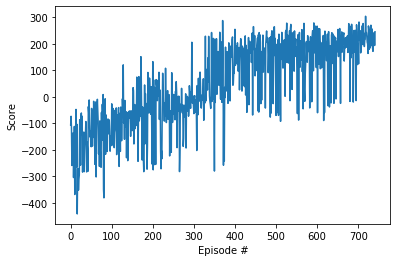

In [222]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 59, 4 %, 0 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 5 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 12 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 11 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 7 %, 0 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 11 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 12 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 9 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 11 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 12 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 12 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 12 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 8 %, 0 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 12 %, 1 %, 6078 MiB, 5123 MiB, 955 MiB
GeForce GTX 1060, 0, 59, 13 %, 1 %, 6078 MiB, 5124 MiB, 954 MiB
GeForce GTX 1060, 0, 59, 9 %, 1 %, 6078 MiB, 5124 MiB, 954 MiB
GeForce GTX 1060, 0, 59, 8 %, 1 %, 6078 MiB, 5124 MiB, 954 MiB
GeForce GTX 1060, 0, 59, 9 %, 1 %, 6078 MiB, 5124 MiB, 954 MiB
```

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [241]:
device = torch.device("cpu")
device

device(type='cpu')

In [248]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [306]:
agent = Agent(state_size=8, action_size=4, seed=0, 
              device=device)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

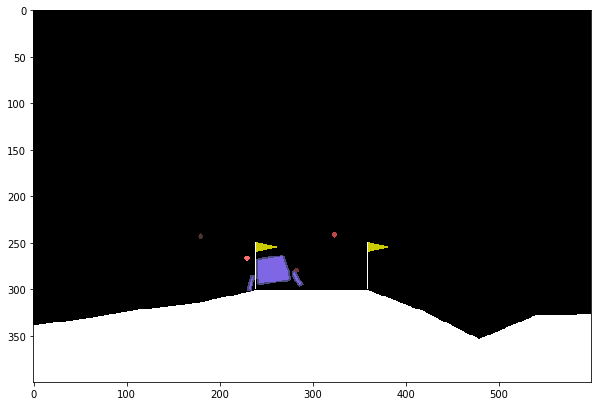

In [293]:
plt.figure(figsize=(10,10))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(300):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()

Save video to file.

In [309]:
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(300):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    if done:
        break

env.close()

Convert mp4 file to GIF.

In [310]:
%%bash
ffmpeg -i ./gym-results/openaigym.video.27.6937.video000000.mp4 ./gifs/003.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

### Hardware Specifications and Software Versions

In [311]:
%%bash
cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [312]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [313]:
%%bash
cat /usr/include/x86_64-linux-gnu/cudnn_v7.h  | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 2
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [314]:
%%bash
nvidia-smi

Thu Sep 19 10:25:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P2    32W /  N/A |   1018MiB /  6078MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [315]:
%%bash
pip freeze

atari-py==0.2.6
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
Box2D==2.3.2
Box2D-kengz==2.3.3
certifi==2019.6.16
cffi==1.12.3
cloudpickle==1.2.2
cycler==0.10.0
Cython==0.29.13
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
future==0.17.1
glfw==1.8.3
gym==0.14.0
imageio==2.5.0
ipykernel==5.1.2
ipython==7.8.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.15.1
Jinja2==2.10.1
jsonschema==3.0.2
jupyter==1.0.0
jupyter-client==5.3.1
jupyter-console==6.0.0
jupyter-core==4.5.0
kiwisolver==1.1.0
lockfile==0.12.2
MarkupSafe==1.1.1
matplotlib==3.1.1
mistune==0.8.4
mkl-fft==1.0.14
mkl-random==1.0.2
mkl-service==2.3.0
mujoco-py==2.0.2.5
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.1
numpy==1.16.5
olefile==0.46
opencv-python==4.1.1.26
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
prometheus-client==0.7.1
prompt-toolkit==2.0.9
ptyprocess==0.6.0
pycparser==2.19
pyglet==1.3.2
Pygments==2.4.2
pyparsing==2.4.2
pyrsistent==0.14.11
python-dateutil==2.8.0
pytz==20

### References

`[1]` Udacity. *Deep Q-Learning Algorithm*. Deep Reinforcement Learning for Enterprise Nanodegree Program, Part 2, Lesson 2. 2019.